<a href="https://colab.research.google.com/github/Rubnserrano/DataScience/blob/main/colorization_prototipo1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from keras.layers import Conv2D, UpSampling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
from skimage.transform import resize
import matplotlib.pyplot as plt
from skimage.io import imsave, imshow
import numpy as np
import tensorflow as tf
from keras.models import Sequential, Model
from skimage.color import rgb2lab, lab2rgb, gray2rgb
import keras
import os
from skimage import io


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [56]:
import zipfile

archivo_zip = '/content/gdrive/MyDrive/image_colorization/images.zip'  # Ruta del archivo ZIP que deseas descomprimir
ruta_destino = '/content/gdrive/MyDrive/image_colorization/'  # Ruta donde deseas extraer los archivos

with zipfile.ZipFile(archivo_zip, 'r') as zip_ref:
    zip_ref.extractall(ruta_destino)


In [57]:
from keras.applications.vgg16 import VGG16
vggmodel = VGG16()
newmodel = Sequential()
#num = 0
for i, layer in enumerate(vggmodel.layers):
    if i<19:          #Only up to 19th layer to include feature extraction only
      newmodel.add(layer)
newmodel.summary()
for layer in newmodel.layers:
  layer.trainable=False   #We don't want to train these layers again, so False.


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [58]:
path = '/content/gdrive/MyDrive/image_colorization/data'
train_datagen = ImageDataGenerator(rescale= 1. / 255)
train = train_datagen.flow_from_directory(path, target_size = (224,224),
                                          batch_size = 100,
                                          class_mode = None,
                                          classes = ['train_color'])

Found 5000 images belonging to 1 classes.


In [59]:
X =[]
Y =[]
for img in train[0]:
  try:
      lab = rgb2lab(img)
      X.append(lab[:,:,0])
      Y.append(lab[:,:,1:] / 128) #A and B values range from -127 to 128,
      #so we divide the values by 128 to restrict values to between -1 and 1.
  except:
     print('error')
X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape+(1,)) #dimensions to be the same for X and Y
print(X.shape)
print(Y.shape)

(100, 224, 224, 1)
(100, 224, 224, 2)


In [60]:
vggfeatures = []
for i, sample in enumerate(X):
  sample = gray2rgb(sample)
  sample = sample.reshape((1,224,224,3))
 # prediction = newmodel.predict(sample)
  prediction = newmodel.predict(sample, verbose = False)

  prediction = prediction.reshape((7,7,512))
  vggfeatures.append(prediction)
vggfeatures = np.array(vggfeatures)


In [53]:
model = Sequential()

model.add(Conv2D(256, (3,3), activation='relu', padding='same', input_shape=(7,7,512)))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.summary()


model.compile(optimizer='Adam', loss='mse' , metrics=['accuracy'])
model.fit(vggfeatures, Y, verbose=1, epochs=10000, batch_size=128)

model.save('colorize_autoencoder_VGG16.model')

Se han truncado las últimas 5000 líneas del flujo de salida.
1/1 [==============================] - 0s 85ms/step - loss: 0.0011 - accuracy: 0.8328
Epoch 7502/10000
1/1 [==============================] - 0s 81ms/step - loss: 0.0011 - accuracy: 0.8389
Epoch 7503/10000
1/1 [==============================] - 0s 85ms/step - loss: 0.0011 - accuracy: 0.8296
Epoch 7504/10000
1/1 [==============================] - 0s 80ms/step - loss: 0.0011 - accuracy: 0.8401
Epoch 7505/10000
1/1 [==============================] - 0s 88ms/step - loss: 0.0011 - accuracy: 0.8311
Epoch 7506/10000
1/1 [==============================] - 0s 106ms/step - loss: 0.0011 - accuracy: 0.8379
Epoch 7507/10000
1/1 [==============================] - 0s 83ms/step - loss: 0.0011 - accuracy: 0.8341
Epoch 7508/10000
1/1 [==============================] - 0s 88ms/step - loss: 0.0011 - accuracy: 0.8351
Epoch 7509/10000
1/1 [==============================] - 0s 85ms/step - loss: 0.0011 - accuracy: 0.8360
Epoch 7510/10000
1/1 [======

# Para que funcione hay que crear la carpeta colorization en ../content/

In [62]:
model = tf.keras.models.load_model('colorize_autoencoder_VGG16.model',
                                   custom_objects=None,
                                   compile=True)
testpath = '/content/gdrive/MyDrive/image_colorization/data/test_black'
files = os.listdir(testpath)

import warnings
warnings.filterwarnings('ignore')

for idx, file in enumerate(files):
    test = img_to_array(load_img(testpath+file))
    test = resize(test, (224,224), anti_aliasing=True)
    test*= 1.0/255
    lab = rgb2lab(test)
    l = lab[:,:,0]
    L = gray2rgb(l)
    L = L.reshape((1,224,224,3))
    #print(L.shape)
    vggpred = newmodel.predict(L, verbose = False)
    ab = model.predict(vggpred, verbose = False)
    #print(ab.shape)
    ab = ab*128
    cur = np.zeros((224, 224, 3))
    cur[:,:,0] = l
    cur[:,:,1:] = ab
    imsave('/content/colorization'+str(idx)+".jpg", lab2rgb(cur))


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 202 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 5 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 31 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 30 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 300 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_sha

1/1 [==============================] - 0s 22ms/step


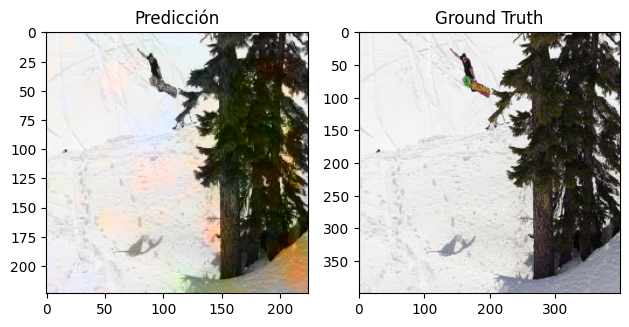

In [64]:
# Comparamos imagenes.
ruta_imagen = '/content/data/test_black/image5150.jpg'
ruta_gt = '/content/data/test_color/image5150.jpg'
import matplotlib.pyplot as plt
# # Abrir la imagen
# imagen = io.imread(ruta_imagen)
# imshow(imagen)

def predecir_y_comparar(path_bw, path_col):
      test = img_to_array(load_img(path_bw))
      test = resize(test, (224,224), anti_aliasing=True)
      test*= 1.0/255
      lab = rgb2lab(test)
      l = lab[:,:,0]
      L = gray2rgb(l)
      L = L.reshape((1,224,224,3))
      vggpred = newmodel.predict(L)
      ab = model.predict(vggpred)
      ab = ab*128
      cur = np.zeros((224, 224, 3))
      cur[:,:,0] = l
      cur[:,:,1:] = ab

      fig, axes = plt.subplots(nrows=1, ncols=2)
      axes[0].imshow(lab2rgb(cur))
      axes[0].set_title('Predicción')

      gt = io.imread(path_col)
      axes[1].imshow(gt)
      axes[1].set_title('Ground Truth')

      plt.tight_layout()
      plt.show()


predecir_y_comparar(ruta_imagen, ruta_gt)


1/1 [==============================] - 0s 20ms/step


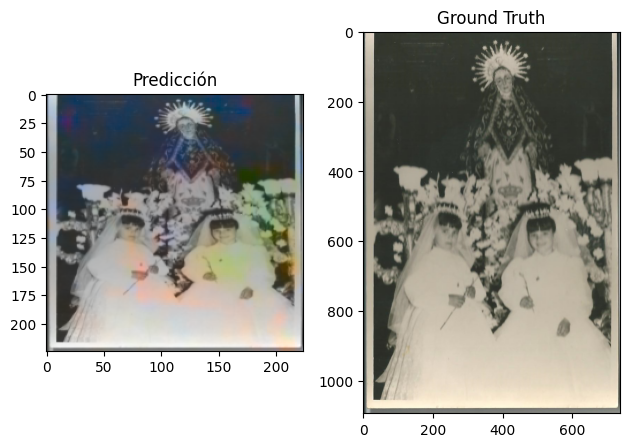

1/1 [==============================] - 0s 21ms/step


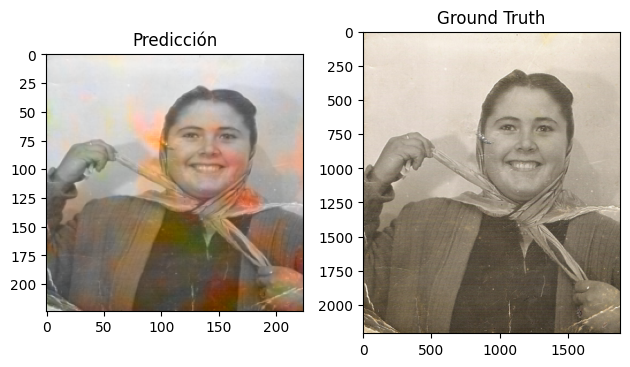

1/1 [==============================] - 0s 22ms/step


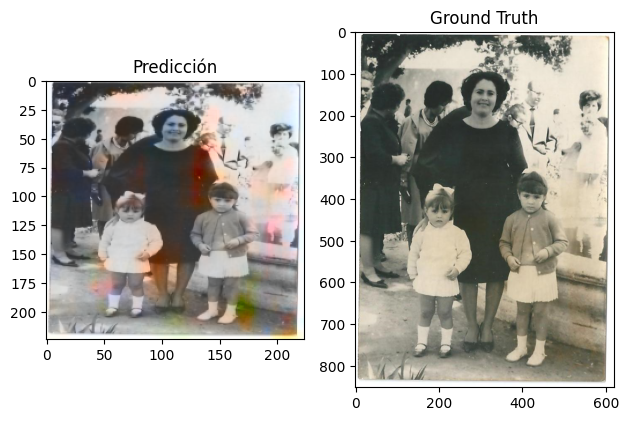

1/1 [==============================] - 0s 36ms/step


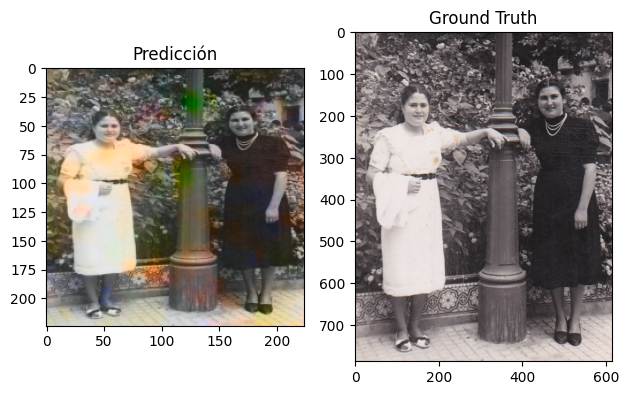

1/1 [==============================] - 0s 27ms/step


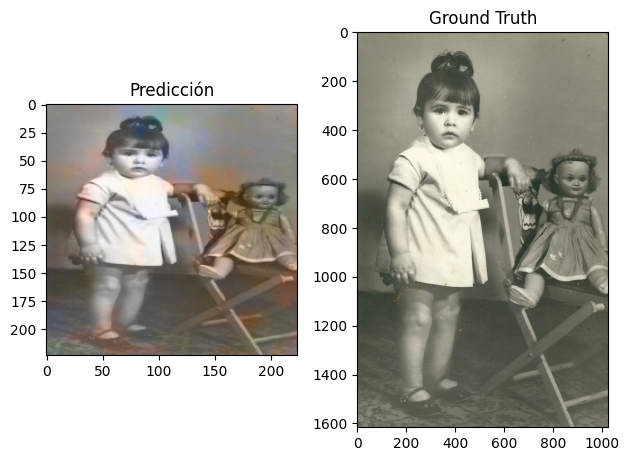

1/1 [==============================] - 0s 30ms/step


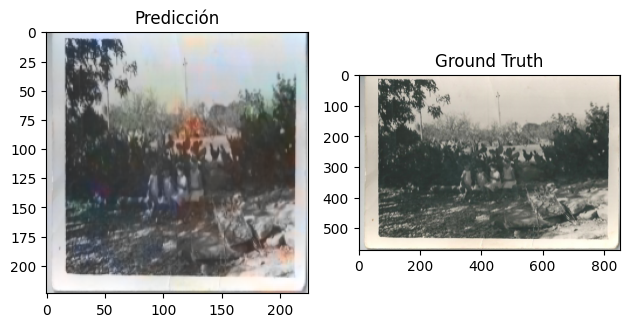

1/1 [==============================] - 0s 27ms/step


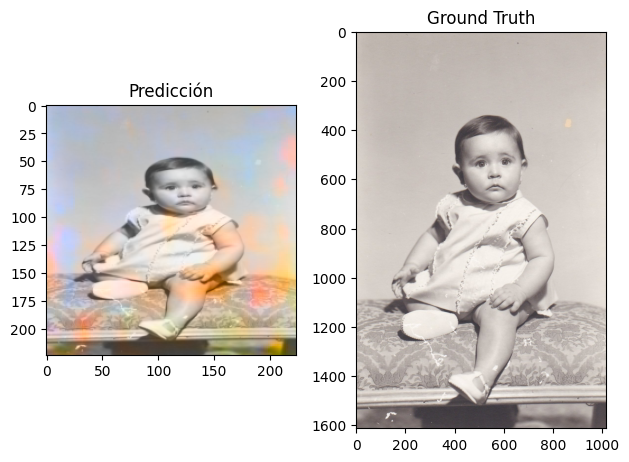

1/1 [==============================] - 0s 27ms/step


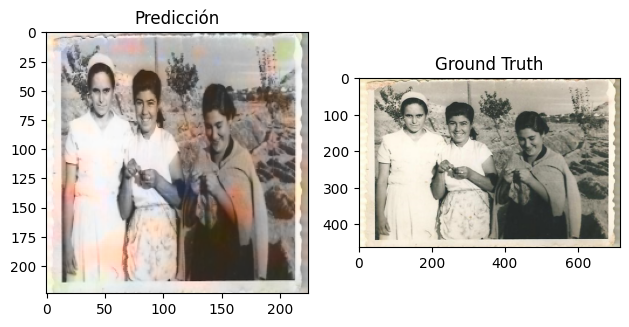

1/1 [==============================] - 0s 32ms/step


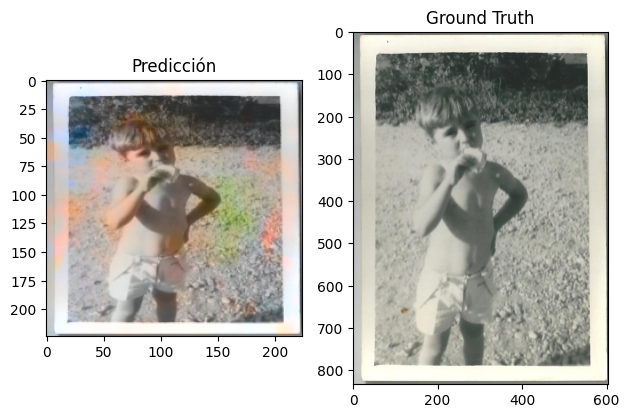

1/1 [==============================] - 0s 45ms/step


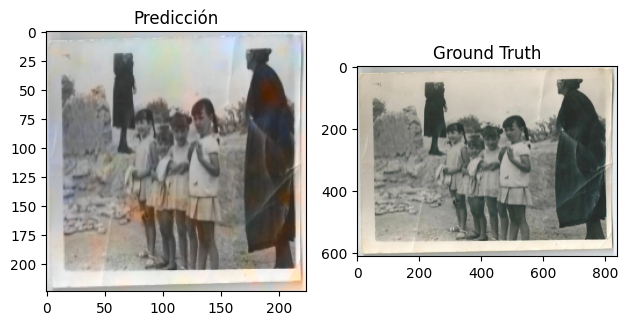

In [65]:
import os

carpeta = '/content/gdrive/MyDrive/fotos_bw/'  # Reemplaza esto con la ruta de la carpeta que deseas explorar

# Obtener la lista de archivos en la carpeta
archivos = os.listdir(carpeta)

# Iterar sobre los archivos y mostrar sus nombres
for archivo in archivos:
    ruta_completa = carpeta + archivo
    predecir_y_comparar(ruta_completa, ruta_completa)



1/1 [==============================] - 0s 31ms/step


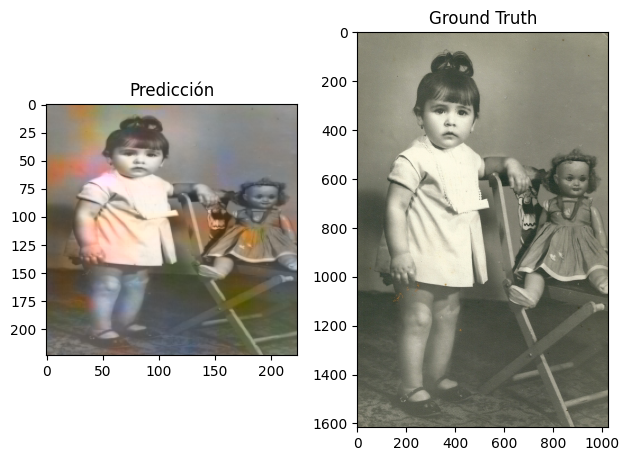

In [44]:
predecir_y_comparar(ruta_fotos_bw, ruta_fotos_bw)


In [30]:
from google.colab import files
files.download('/content/colorize_autoencoder_VGG16.model')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>